In [89]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import math

In [ ]:
ds_train, info_train = tfds.load('stl10', split='train', with_info=True, shuffle_files=True, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

In [4]:
ds_test, info_test = tfds.load('stl10', split='test', with_info=True, shuffle_files=True, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[140, 174, 166], [136, 170, 165], [133, 170,...",6
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[171, 183, 180], [173, 184, 181], [174, 185,...",8
4,"[[[24, 28, 19], [43, 49, 29], [58, 68, 34], [6...",6


In [90]:
x_train=[]
y_train=[]
for data in ds_train:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_train.append(x)
  y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape

(5000, 96, 96, 3)

In [91]:
y_train = pd.get_dummies(y_train)
y_train.shape

(5000, 10)

In [92]:
x_test=[]
y_test=[]

for data in ds_test:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = pd.get_dummies(y_test)

In [93]:
x_test.shape

(8000, 96, 96, 3)

In [94]:
y_test.shape

(8000, 10)

In [95]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [96]:
training_set = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

In [97]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

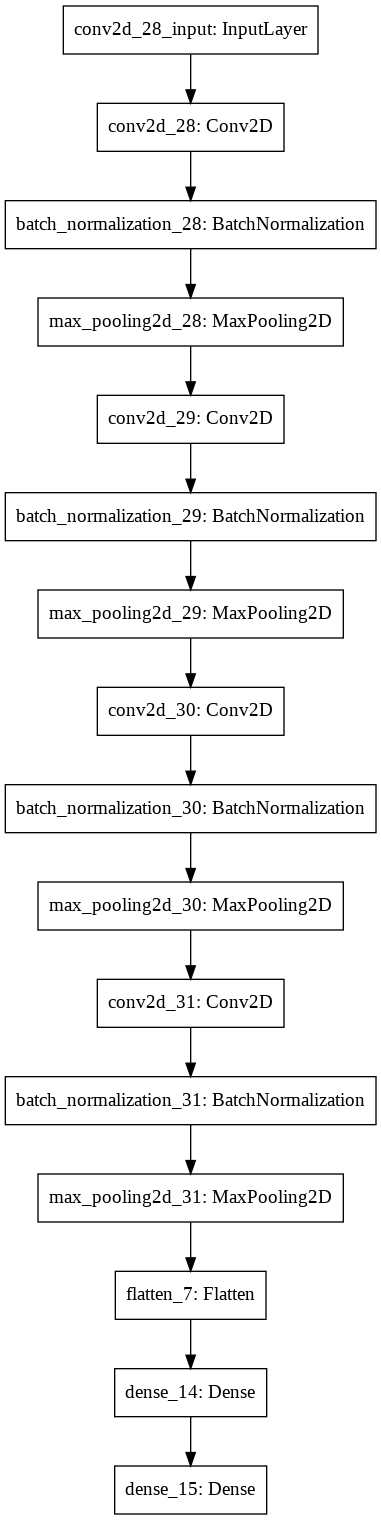

In [98]:
cnn=tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=96,kernel_size=3,activation='relu',input_shape=[96,96,3]))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=72,kernel_size=3,activation='relu', bias_regularizer=regularizers.l1(0.00005)))
tf.keras.layers.Dropout(rate=0.2)
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', bias_regularizer=regularizers.l1(0.00005)))
tf.keras.layers.Dropout(rate=0.2)
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu', bias_regularizer=regularizers.l1(0.00005)))
tf.keras.layers.Dropout(rate=0.2)
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))
cnn.add(tf.keras.layers.Dense(units=10,activation='softmax'))
plot_model(cnn)

In [99]:
stop = EarlyStopping(patience=25)

In [100]:
opt=tf.keras.optimizers.Adam(learning_rate=0.00005)

In [101]:
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [102]:
cnn.fit(x=training_set, validation_data=test_set, epochs= 160, batch_size=32, callbacks=[stop])

Epoch 1/160
157/157 [==============================] - 15s 90ms/step - loss: 2.4378 - accuracy: 0.2032 - val_loss: 2.4797 - val_accuracy: 0.1066
Epoch 2/160
157/157 [==============================] - 14s 88ms/step - loss: 1.9996 - accuracy: 0.2892 - val_loss: 2.3918 - val_accuracy: 0.1851
Epoch 3/160
157/157 [==============================] - 14s 88ms/step - loss: 1.8290 - accuracy: 0.3298 - val_loss: 2.0317 - val_accuracy: 0.2724
Epoch 4/160
157/157 [==============================] - 14s 88ms/step - loss: 1.7610 - accuracy: 0.3480 - val_loss: 1.6517 - val_accuracy: 0.3801
Epoch 5/160
157/157 [==============================] - 14s 89ms/step - loss: 1.6857 - accuracy: 0.3728 - val_loss: 1.5731 - val_accuracy: 0.4140
Epoch 6/160
157/157 [==============================] - 14s 89ms/step - loss: 1.6447 - accuracy: 0.3846 - val_loss: 1.5417 - val_accuracy: 0.4279
Epoch 7/160
157/157 [==============================] - 14s 89ms/step - loss: 1.5829 - accuracy: 0.4074 - val_loss: 1.5249 - val_ac